In [43]:
import fitz  # PyMuPDF for PDF handling
from PIL import Image, ImageDraw, ImageFont  # Image processing
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad
import base64
import os
from IPython.display import display
import json

In [44]:
def pdf_to_images(pdf_path, num_pages=2):
    pdf_document = fitz.open(pdf_path)
    images = []
    for page_num in range(min(num_pages, pdf_document.page_count)):
        page = pdf_document[page_num]
        pix = page.get_pixmap()  # Render page as pixel map
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
    pdf_document.close()
    return images

📄 Page 1 with bounding boxes (saved at text_boxes_images\text_boxes_page_1.png)


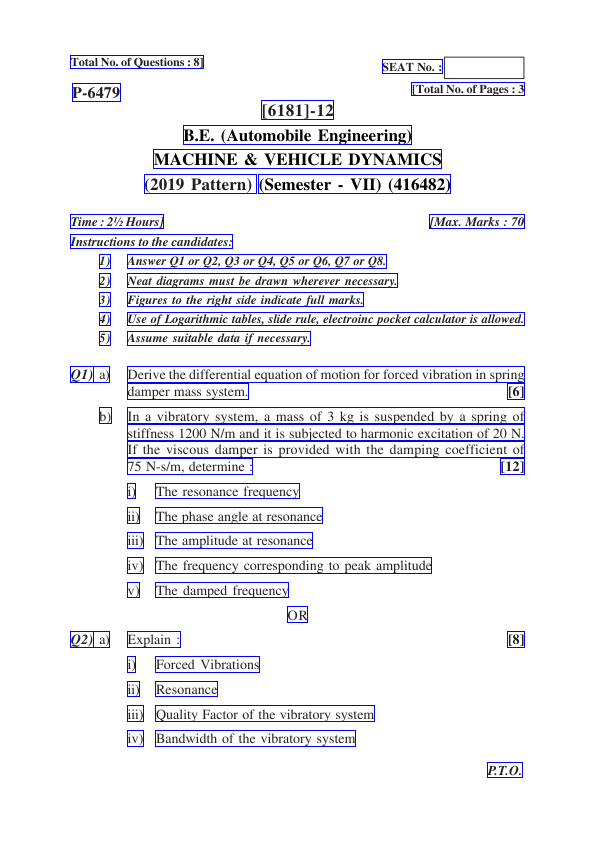

📄 Page 2 with bounding boxes (saved at text_boxes_images\text_boxes_page_2.png)


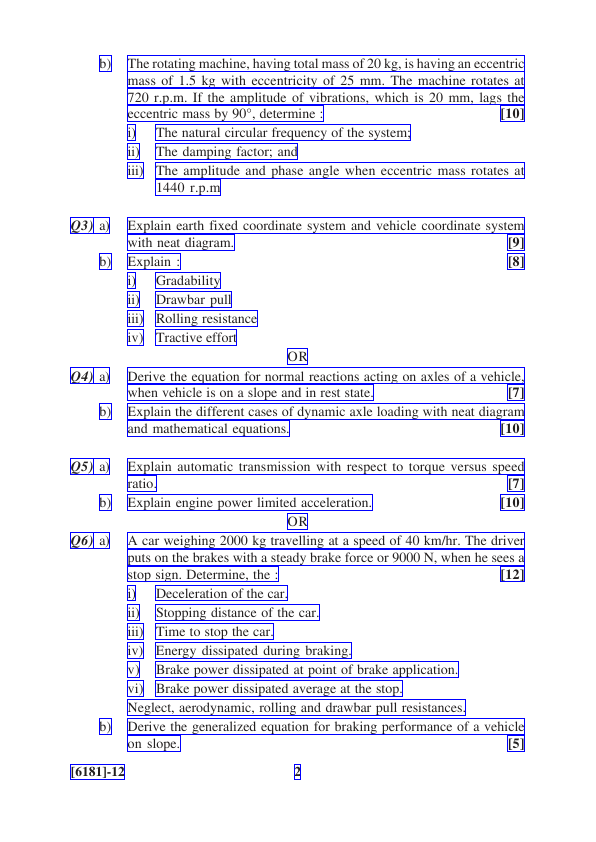

📄 Page 3 with bounding boxes (saved at text_boxes_images\text_boxes_page_3.png)


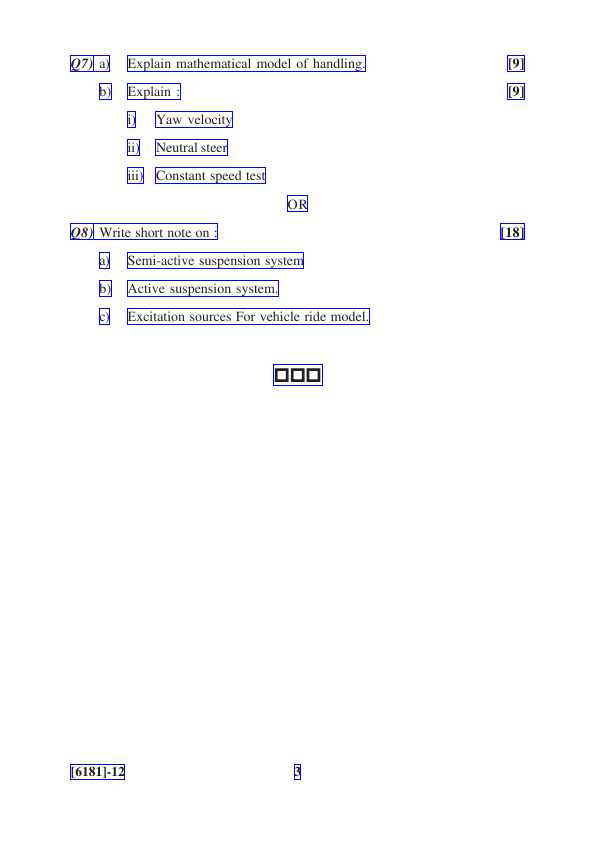

[[(70.8499984741211, 366.43603515625, 93.2863998413086, 382.3120422363281, 'Q1)'), (93.2863998413086, 366.43603515625, 109.61320495605469, 382.3120422363281, 'a)'), (127.61299896240234, 366.43603515625, 524.490234375, 382.3120422363281, 'Derive the differential equation of motion for forced vibration in spring'), (127.61019897460938, 383.23602294921875, 248.3378143310547, 399.1120300292969, 'damper mass system.'), (507.89080810546875, 383.23602294921875, 524.32958984375, 399.1120300292969, '[6]'), (99.17062377929688, 407.955810546875, 111.17002868652344, 423.8318176269531, 'b)'), (127.6102294921875, 407.955810546875, 524.426513671875, 423.8318176269531, 'In a vibratory system, a mass of 3 kg is suspended by a spring of'), (127.61022186279297, 424.75579833984375, 524.5029296875, 440.6318054199219, 'stiffness 1200 N/m and it is subjected to harmonic excitation of 20 N.'), (127.61022186279297, 441.5557861328125, 524.5272827148438, 457.4317932128906, 'If the viscous damper is provided with

In [45]:
import os
import fitz  # PyMuPDF
from PIL import Image, ImageDraw
from IPython.display import display

def get_text_boxwise_and_show_boxes(pdf_path, min_pages=1, max_pages=5, output_dir="text_boxes_images"):
    pdf_document = fitz.open(pdf_path)
    all_text_boxes = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Make sure we process between min_pages and max_pages, within the available page count
    total_pages = pdf_document.page_count
    pages_to_process = max(min(total_pages, max_pages), min_pages)

    for page_num in range(pages_to_process):
        page = pdf_document[page_num]
        text_boxes = []

        # Get structured text layout
        page_dict = page.get_text("dict")

        # Render page to image
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        draw = ImageDraw.Draw(img)

        # Loop through blocks -> lines -> spans
        for block in page_dict["blocks"]:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        x0, y0, x1, y1 = span["bbox"]
                        text = span["text"].strip()
                        if text:
                            text_boxes.append((x0, y0, x1, y1, text))
                            draw.rectangle([x0, y0, x1, y1], outline="blue", width=1)

        all_text_boxes.append(text_boxes)

        # Save and show image
        output_file = os.path.join(output_dir, f"text_boxes_page_{page_num + 1}.png")
        img.save(output_file)
        print(f"📄 Page {page_num + 1} with bounding boxes (saved at {output_file})")
        display(img)

    pdf_document.close()
    return all_text_boxes

pdf_path = "question_paper_pdf_dataset_3_5.pdf"
text_boxes = get_text_boxwise_and_show_boxes(pdf_path, min_pages=1, max_pages=5)
print(text_boxes)


In [ ]:
import os
import json
import base64
import fitz  # PyMuPDF
from PIL import Image, ImageDraw, ImageFont
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad
import hmac
import hashlib

# 🔐 AES encryption with HMAC
def aes_encrypt(text, key_base64):
    key_bytes = base64.b64decode(key_base64)
    key_hash = hashlib.sha256(key_bytes).digest()
    iv = get_random_bytes(16)
    cipher = AES.new(key_hash, AES.MODE_CBC, iv)
    padded_text = pad(text.encode(), AES.block_size)
    encrypted_bytes = cipher.encrypt(padded_text)
    mac = hmac.new(key_hash, iv + encrypted_bytes, hashlib.sha256).digest()
    encrypted_data = base64.b64encode(iv + encrypted_bytes + mac).decode('utf-8')
    return encrypted_data

# ✂️ Truncate text to fit box
def truncate_text_to_fit(draw, text, box_width, font_path, font_size=10):
    font = ImageFont.truetype(font_path, font_size)
    while draw.textlength(text, font=font) > box_width:
        if len(text) <= 4:
            return "..."
        text = text[:-4] + "..."
    return text

# 🖍️ Draw text centered inside box
def draw_text_in_box(draw, text, box, font, fill="black"):
    x0, y0, x1, y1 = box
    box_height = y1 - y0
    text_bbox = font.getbbox("A")
    text_height = text_bbox[3] - text_bbox[1]
    y_centered = y0 + (box_height - text_height) / 2
    draw.text((x0, y_centered), text, font=font, fill=fill)

# 🔄 Main encryption and image generation function
def replace_text_with_encrypted_images_accurate(
    pdf_path,
    text_boxes,
    output_dir="encrypted_output_accurate",
    font_path="C:\\Windows\\Fonts\\arial.ttf",
    save_json_path="saved_boxes_with_encryption.json"
):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # ✅ Generate and display encryption key
    key = get_random_bytes(16)
    key_base64 = base64.b64encode(key).decode('utf-8')
    print(f"\n🔐 AES Key (keep this safe to decrypt): {key_base64}\n")

    pdf_document = fitz.open(pdf_path)
    encrypted_data_to_save = []

    for page_num, page_boxes in enumerate(text_boxes):
        page = pdf_document[page_num]
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        draw = ImageDraw.Draw(img)

        page_info = []

        for box in page_boxes:
            x0, y0, x1, y1, original_text = box
            encrypted_text = aes_encrypt(original_text, key_base64)

            # Save encrypted and original text with bounding box
            page_info.append((x0, y0, x1, y1, encrypted_text, original_text))

            box_width = x1 - x0
            box_height = y1 - y0
            font_size = max(8, int(box_height))
            font = ImageFont.truetype(font_path, font_size)

            # Truncate for visual fitting
            encrypted_short = truncate_text_to_fit(draw, encrypted_text, box_width, font_path, font_size)

            # Draw encrypted short text
            draw.rectangle([x0, y0, x1, y1], fill="white")
            draw_text_in_box(draw, encrypted_short, (x0, y0, x1, y1), font)

        # Save image of the encrypted page
        output_path = os.path.join(output_dir, f"encrypted_page_{page_num + 1}.png")
        img.save(output_path)
        print(f"✅ Encrypted image saved: {output_path}")
        display(img)  

        encrypted_data_to_save.append(page_info)

    pdf_document.close()

    # Save encrypted data to JSON
    with open(save_json_path, "w", encoding="utf-8") as f:
        json.dump(encrypted_data_to_save, f, indent=2)
    print(f"\n📝 Encrypted box data saved to: {save_json_path}")



🔐 AES Key (keep this safe to decrypt): V/+3mGEGmXo9z2Dgtqkz9w==

✅ Encrypted image saved: encrypted_output_accurate\encrypted_page_1.png


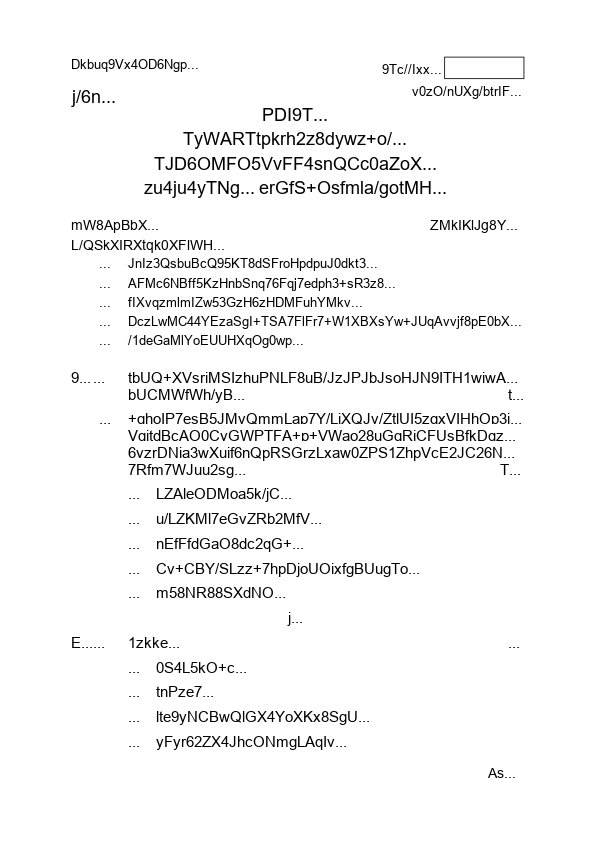

✅ Encrypted image saved: encrypted_output_accurate\encrypted_page_2.png


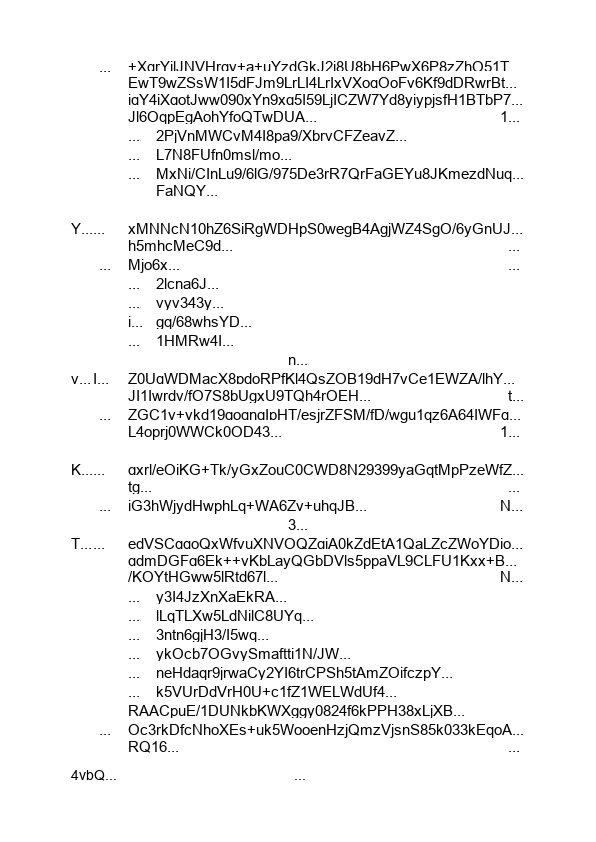

✅ Encrypted image saved: encrypted_output_accurate\encrypted_page_3.png


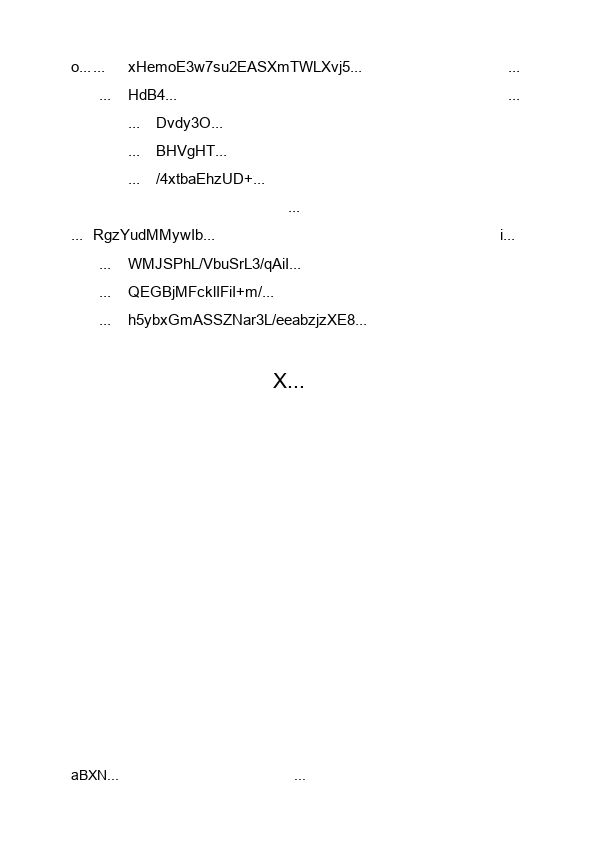


📝 Encrypted box data saved to: saved_boxes_with_encryption.json


In [40]:
replace_text_with_encrypted_images_accurate(
    pdf_path="question_paper_pdf_dataset_3_5.pdf",
    text_boxes=text_boxes,
    font_path="C:\\Windows\\Fonts\\arial.ttf"
)


In [1]:
import os
import img2pdf
from PIL import Image
from IPython.display import display, FileLink

def convert_encrypted_images_to_pdf(
    encrypted_images_dir="encrypted_output_accurate",
    output_pdf_path="encrypted_output.pdf"
):
    # Get all encrypted image files in the directory
    image_files = [
        os.path.join(encrypted_images_dir, f)
        for f in os.listdir(encrypted_images_dir)
        if f.endswith(".png") and f.startswith("encrypted_page_")
    ]
    
    # Sort files by page number
    image_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    
    # Convert images to PDF
    with open(output_pdf_path, "wb") as pdf_file:
        pdf_file.write(img2pdf.convert(image_files))
    
    print(f"✅ Encrypted images converted to PDF: {output_pdf_path}")
    display(FileLink(output_pdf_path))

# Example usage
convert_encrypted_images_to_pdf()

✅ Encrypted images converted to PDF: encrypted_output.pdf


d:\code\encryption\encryption\dataset\encrypted_output.pdf

In [5]:
import os
import json
import base64
import fitz  # PyMuPDF
from PIL import Image, ImageDraw, ImageFont
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad
import hmac
import hashlib
import img2pdf

# Your saved AES key from encryption
aes_key_base64 = "V/+3mGEGmXo9z2Dgtqkz9w=="  # REPLACE WITH YOUR ACTUAL KEY

def aes_decrypt(encrypted_text, key_base64):
    try:
        key_bytes = base64.b64decode(key_base64)
        key_hash = hashlib.sha256(key_bytes).digest()
        raw = base64.b64decode(encrypted_text)
        iv = raw[:16]
        encrypted = raw[16:-32]
        mac = raw[-32:]
        
        # Verify HMAC
        expected_mac = hmac.new(key_hash, iv + encrypted, hashlib.sha256).digest()
        if not hmac.compare_digest(mac, expected_mac):
            raise ValueError("HMAC verification failed")
        
        cipher = AES.new(key_hash, AES.MODE_CBC, iv)
        decrypted = cipher.decrypt(encrypted)
        return unpad(decrypted, AES.block_size).decode("utf-8")
    except Exception as e:
        print(f"Decryption failed: {str(e)}")
        return "[DECRYPTION ERROR]"

def decrypt_and_generate_clean_pdf(
    box_data_path="saved_boxes_with_encryption.json",
    encrypted_pdf_path="encrypted_output.pdf",
    output_pdf_path="clean_decrypted_output.pdf",
    font_path="C:\\Windows\\Fonts\\arial.ttf",
    dpi=300
):
    # Load the encrypted data
    with open(box_data_path, "r", encoding="utf-8") as f:
        all_data = json.load(f)

    # Open the encrypted PDF
    pdf_document = fitz.open(encrypted_pdf_path)
    
    # Create temporary directory
    temp_dir = "temp_clean_pages"
    os.makedirs(temp_dir, exist_ok=True)
    decrypted_images = []

    for page_num, page_data in enumerate(all_data):
        if page_num >= len(pdf_document):
            break

        # Create blank white page with same dimensions
        page = pdf_document[page_num]
        zoom = dpi / 72  # PDF uses 72 DPI
        width = int(page.rect.width * zoom)
        height = int(page.rect.height * zoom)
        
        # Create blank white image
        img = Image.new("RGB", (width, height), "white")
        draw = ImageDraw.Draw(img)

        for box_info in page_data:
            if len(box_info) >= 6:  # Ensure we have all required elements
                try:
                    x0, y0, x1, y1 = box_info[0], box_info[1], box_info[2], box_info[3]
                    encrypted_text = box_info[4]
                    
                    # Decrypt the text
                    decrypted_text = aes_decrypt(encrypted_text, aes_key_base64)
                    
                    # Calculate scaled coordinates
                    scaled_x0, scaled_y0 = x0 * zoom, y0 * zoom
                    scaled_x1, scaled_y1 = x1 * zoom, y1 * zoom
                    box_height = scaled_y1 - scaled_y0
                    
                    # Determine optimal font size (80% of box height)
                    font_size = int(box_height * 0.8)
                    try:
                        font = ImageFont.truetype(font_path, font_size)
                    except:
                        font = ImageFont.load_default()
                    
                    # Draw only the decrypted text on clean white background
                    draw.text(
                        (scaled_x0, scaled_y0),
                        decrypted_text,
                        font=font,
                        fill="black"
                    )
                except Exception as e:
                    print(f"Error processing box on page {page_num+1}: {str(e)}")

        # Save decrypted page image
        temp_path = os.path.join(temp_dir, f"clean_page_{page_num+1}.png")
        img.save(temp_path, dpi=(dpi, dpi))
        decrypted_images.append(temp_path)
        print(f"Processed page {page_num + 1}")

    # Generate final PDF
    with open(output_pdf_path, "wb") as pdf_file:
        pdf_file.write(img2pdf.convert(decrypted_images))

    # Cleanup temporary files
    for img_path in decrypted_images:
        os.remove(img_path)
    os.rmdir(temp_dir)
    
    print(f"\nSuccessfully created clean decrypted PDF: {output_pdf_path}")

# Run the decryption
decrypt_and_generate_clean_pdf()

Processed page 1
Processed page 2
Processed page 3

Successfully created clean decrypted PDF: clean_decrypted_output.pdf


✅ Decrypted image saved: decrypted_output\decrypted_page_1.png


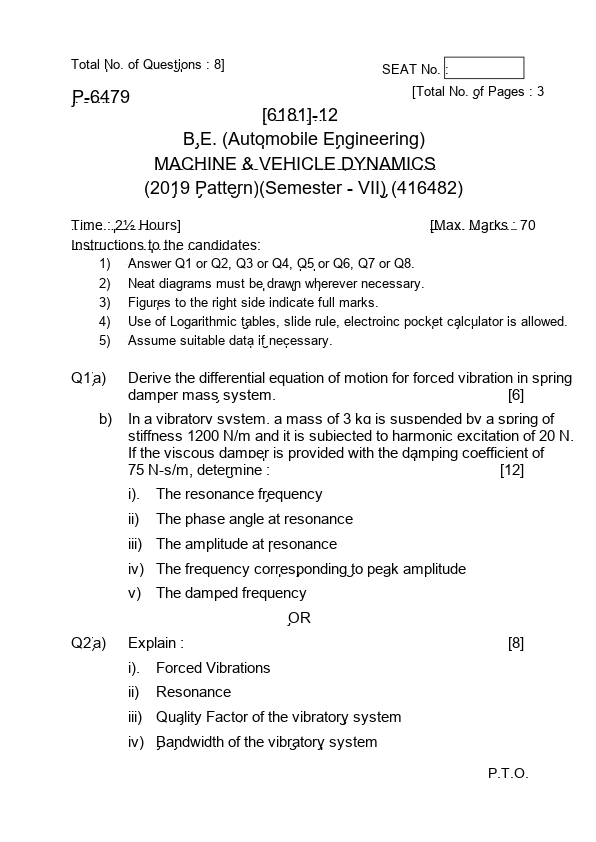

✅ Decrypted image saved: decrypted_output\decrypted_page_2.png


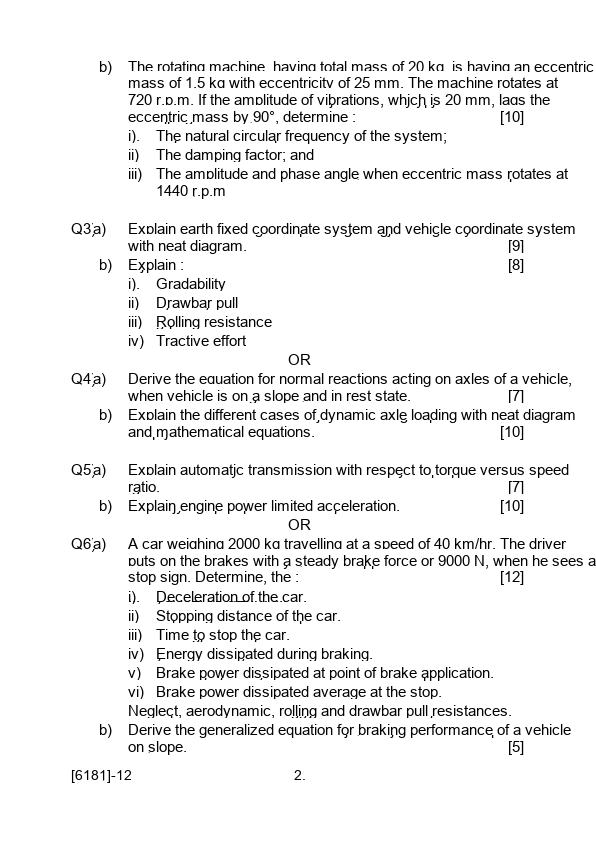

✅ Decrypted image saved: decrypted_output\decrypted_page_3.png


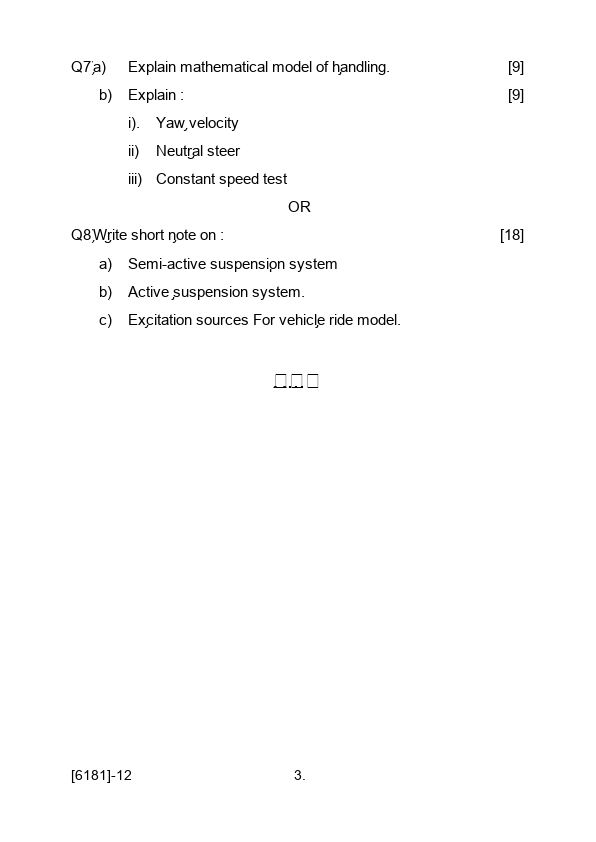

In [ ]:
# import os
# import json
# import base64
# from PIL import Image, ImageDraw, ImageFont
# from Crypto.Cipher import AES
# from Crypto.Util.Padding import unpad
# import hmac
# import hashlib

# # Your saved AES key from encryption
# aes_key_base64 = "V/+3mGEGmXo9z2Dgtqkz9w=="  # Replace this with your actual key

# # 🔓 AES decryption with HMAC verification
# def aes_decrypt(encrypted_text, key_base64):
#     key_bytes = base64.b64decode(key_base64)
#     key_hash = hashlib.sha256(key_bytes).digest()

#     raw = base64.b64decode(encrypted_text)
#     iv = raw[:16]
#     encrypted = raw[16:-32]
#     mac = raw[-32:]

#     # HMAC check
#     expected_mac = hmac.new(key_hash, iv + encrypted, hashlib.sha256).digest()
#     if not hmac.compare_digest(mac, expected_mac):
#         raise ValueError("⚠️ HMAC verification failed: data may be tampered.")

#     cipher = AES.new(key_hash, AES.MODE_CBC, iv)
#     decrypted = cipher.decrypt(encrypted)
#     return unpad(decrypted, AES.block_size).decode("utf-8")

# # Draw text centered inside the box
# def draw_text_in_box(draw, text, box, font, fill="black"):
#     x0, y0, x1, y1 = box
#     box_height = y1 - y0
#     text_bbox = font.getbbox("A")
#     text_height = text_bbox[3] - text_bbox[1]
#     y_centered = y0 + (box_height - text_height) / 2
#     draw.text((x0, y_centered), text, font=font, fill=fill)

# # 🔁 Decrypt and restore text to images
# def decrypt_and_restore_images(
#     box_data_path,
#     encrypted_img_dir,
#     output_dir="decrypted_output",
#     font_path="C:\\Windows\\Fonts\\arial.ttf"
# ):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     key_base64 = aes_key_base64
#     with open(box_data_path, "r", encoding="utf-8") as f:
#         all_data = json.load(f)

#     for page_num, page_data in enumerate(all_data):
#         img_path = os.path.join(encrypted_img_dir, f"encrypted_page_{page_num + 1}.png")
#         if not os.path.exists(img_path):
#             print(f"❌ Image not found: {img_path}")
#             continue

#         img = Image.open(img_path)
#         draw = ImageDraw.Draw(img)

#         for x0, y0, x1, y1, encrypted_text, original_text in page_data:
#             try:
#                 decrypted = aes_decrypt(encrypted_text, key_base64)
#             except Exception as e:
#                 print(f"⚠️ Decryption error: {e}")
#                 decrypted = "[Decryption Error]"

#             box_width = x1 - x0
#             box_height = y1 - y0
#             font_size = max(8, int(box_height))
#             font = ImageFont.truetype(font_path, font_size)

#             draw.rectangle([x0, y0, x1, y1], fill="white")
#             draw_text_in_box(draw, decrypted, (x0, y0, x1, y1), font)

#         output_path = os.path.join(output_dir, f"decrypted_page_{page_num + 1}.png")
#         img.save(output_path)
#         print(f"✅ Decrypted image saved: {output_path}")
#         display(img)
        

# # ✅ Run the function
# decrypt_and_restore_images(
#     box_data_path="saved_boxes_with_encryption.json",
#     encrypted_img_dir="encrypted_output_accurate",
#     output_dir="decrypted_output"
# )


In [2]:
from PIL import Image
import os

def images_to_pdf(image_dir, output_pdf_path):
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.endswith(".png")],
        key=lambda x: int(x.split("_")[-1].split(".")[0])  # Sort by page number
    )

    if not image_files:
        print("❌ No images found in the directory.")
        return

    image_paths = [os.path.join(image_dir, img) for img in image_files]
    images = [Image.open(img_path).convert("RGB") for img_path in image_paths]

    first_image = images[0]
    remaining_images = images[1:]

    output_pdf_path = output_pdf_path if output_pdf_path.endswith(".pdf") else output_pdf_path + ".pdf"
    first_image.save(output_pdf_path, save_all=True, append_images=remaining_images)

    print(f"📄 Decrypted PDF saved as: {output_pdf_path}")

# ✅ Convert decrypted images to PDF
images_to_pdf(
    image_dir="decrypted_output",
    output_pdf_path="decrypted_question_paper.pdf"
)


📄 Decrypted PDF saved as: decrypted_question_paper.pdf
